In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2 as cv
import torch
import torchvision
import os
import logging
import warnings


from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms, models, ops
from tqdm.notebook import tqdm

# import pytorch_lightning as pl
# from torchmetrics.detection.mean_ap import MeanAveragePrecision
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

plt.rcParams['figure.constrained_layout.use'] = True

In [ ]:
warnings.filterwarnings('ignore')

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
os.chdir('/content/drive/MyDrive/CIS_680_HW4/CIS_680_HW4')
import torch.optim as optim 

Mounted at /content/drive/


In [ ]:
try:
    from dataset import BuildDataset, BuildDataLoader
    from rpn import *
    from utils import *
except ModuleNotFoundError:
    pass

# 1. Data Loading

In [ ]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]

In [ ]:
# Load data into Dataset class
dataset = BuildDataset(paths)

# build the dataloader, set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# push the randomized training data into the dataloader
batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

# 2. Scale And Aspect Ratio Plots for Dataset

Median Scale:  154.49417114257812 
Median Ratio:  1.042075753211975


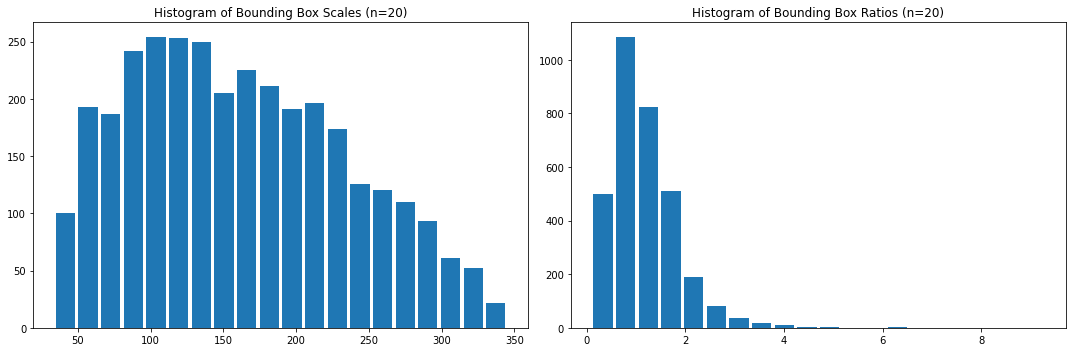

In [ ]:
num_samples = len(dataset.bboxes)
scales = np.zeros(num_samples)
ratios = np.zeros(num_samples)

for i, bbox in enumerate(dataset.bboxes):
    [x1, y1, x2, y2] = bbox[0]
    w = x2 - x1
    h = y2 - y1
    scales[i] = np.sqrt(w*h)
    ratios[i] = w/h
    
print("Median Scale: ", np.median(scales), "\nMedian Ratio: ", np.median(ratios))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.hist(scales, bins=20, rwidth=0.85)
plt.title("Histogram of Bounding Box Scales (n=20)")

ax = fig.add_subplot(1, 2, 2)
ax.hist(ratios, bins=20, rwidth=0.85)
plt.title("Histogram of Bounding Box Ratios (n=20)")

fig.tight_layout()
plt.show()

# 3. Vizualize Dataset and Target

In [ ]:
def vizualize_dataset(data):
    colors = ['r', 'b', 'g']
    
    images, labels, masks, bboxes, index= data['images'], data['labels'], data['masks'], data['bbox'], data['index']
    batch_size = len(images)

    fig = plt.figure(figsize=(20, 2*batch_size*15))

    for num in range(batch_size):
        objs = len(labels[num])
        ax = fig.add_subplot(1, batch_size+1, num + 1)
        ax.imshow(torch.moveaxis(images[num], 0, -1))
        for i in range(objs):
            idx = torch.argwhere(masks[num][i] > 0)
            ax.scatter(idx[:, 1], idx[:, 0], alpha=0.01, c=colors[int(labels[num][i]) - 1])
            rect = patches.Rectangle((bboxes[num][i][0], bboxes[num][i][1]),
                                        bboxes[num][i][2] - bboxes[num][i][0],
                                        bboxes[num][i][3] - bboxes[num][i][1], linewidth=2,
                                        edgecolor=colors[int(labels[num][i]) - 1], facecolor='none')
            ax.add_patch(rect)

    plt.show()

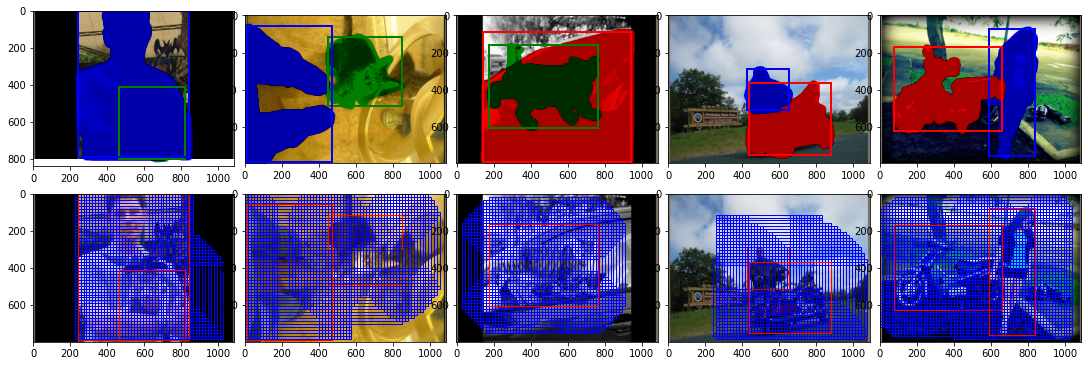

In [ ]:
which = 0
num=5
colors = ['r', 'b', 'g']

fig = plt.figure(figsize=(15, num))
fig.tight_layout()

rpn_net = RPNHead()

for iter, data in enumerate(train_loader):
    images  = data['images'][0]
    labels  = data['labels'][0]
    masks   = data['masks'][0]
    indexes = data['index']
    bboxes   = data['bbox']
    
    if len(labels)<=1:
        continue
    if (int(labels[0]) == int(labels[1])):
        continue

    # Create ground truth anchors
    gt, ground_coord = rpn_net.create_batch_truth(bboxes, indexes, images.shape[-2:])

    # Flatten the ground truth and the anchors
    flatten_coord, flatten_gt, flatten_anchors = output_flattening(ground_coord, gt, rpn_net.get_anchors())

    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
    decoded_coord = output_decoding(flatten_coord, flatten_anchors)


    images = transforms.functional.normalize(images,
                                                 [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                 [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
    objs = len(labels)
    ax = fig.add_subplot(2, num, which + 1)
    ax.imshow(torch.moveaxis(images, 0, -1))

    for i in range(objs):
        idx = torch.argwhere(masks[i] > 0)
        ax.scatter(idx[:, 1], idx[:, 0], alpha=0.01, c=colors[int(labels[i]) - 1])
        rect = patches.Rectangle((bboxes[0][i][0], bboxes[0][i][1]),
                                    bboxes[0][i][2] - bboxes[0][i][0],
                                    bboxes[0][i][3] - bboxes[0][i][1], linewidth=2,
                                    edgecolor=colors[int(labels[i]) - 1], facecolor='none')
        ax.add_patch(rect)

    ax = fig.add_subplot(2, num, num + which + 1)
    ax.imshow(torch.moveaxis(images, 0, -1))

    find_cor = (flatten_gt == 1).nonzero()
    find_neg = (flatten_gt == -1).nonzero()

    for elem in find_cor:
        coord = decoded_coord[elem, :].view(-1)
        anchor = flatten_anchors[elem, :].view(-1)

        col = 'r'
        rect = patches.Rectangle((coord[0], coord[1]), coord[2] - coord[0], coord[3] - coord[1], fill=False,
                                    color=col)
        ax.add_patch(rect)
        rect = patches.Rectangle((anchor[0] - anchor[2] / 2, anchor[1] - anchor[3] / 2), anchor[2], anchor[3],
                                    fill=False, color='b')
        ax.add_patch(rect)

    
    which+= 1

    if which == num:
      plt.show()
      break

# 4. Taining Loop

In [ ]:
try:
    from dataset import BuildDataset, BuildDataLoader
    from rpn import *
    from utils import *
except ModuleNotFoundError:
    pass

In [ ]:
# Load data into Dataset class
dataset = BuildDataset(paths)

# build the dataloader, set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# push the randomized training data into the dataloader
batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
model = RPNHead().to(device)
epochs = 30

optimizer = optim.SGD(model.parameters(),lr = 0.001,momentum=0.90)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,35], gamma=0.20)

train_loss, train_class_loss, train_regr_loss = [], [], []
test_loss, test_class_loss, test_regr_loss = [], [], []

for epoch in range(epochs):
    running_loss = 0.0
    class_loss = 0.0
    regr_loss = 0.0
    
    for i, data in enumerate(train_loader):
        model.train()

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['images'], data['labels']
        images = data['images'][0]
        idx = data['index']
        bbox = data['bbox']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        gt_class, ground_coord= model.create_batch_truth(bbox, idx, images.shape[-2:]) 
        class_head, regr_head = model.forward(inputs.type(torch.float).to(device))
        loss, loss_class, loss_regr = model.compute_loss(class_head.to(device), regr_head.to(device), gt_class.to(device), ground_coord.to(device), effective_batch=batch_size*16)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        class_loss += loss_class.item()
        regr_loss += loss_regr.item()    
    running_loss = running_loss / len(train_loader)
    class_loss = class_loss / len(train_loader)
    regr_loss = regr_loss / len(train_loader)

    train_loss.append(running_loss)
    train_class_loss.append(class_loss)
    train_regr_loss.append(regr_loss)
    print("Train Loss for epoch "+ str(epoch+1) + ". Total Loss = " + str(running_loss) + ". Classifier Loss = " + str(class_loss) + ". Regressor Loss = " + str(regr_loss))

    loss_test = 0.0
    loss_class_test = 0.0
    loss_regr_test = 0.0
    for j, test_data in enumerate(test_loader):
      model.eval()
      inputs, labels = test_data['images'], test_data['labels']
      images = test_data['images'][0]
      idx = test_data['index']
      bbox = test_data['bbox']

      gt_class, ground_coord = model.create_batch_truth(bbox,idx,images.shape[-2:]) 
      class_head, regr_head = model.forward(inputs.type(torch.float).to(device))
      loss, loss_class, loss_regr = model.compute_loss(class_head.to(device), regr_head.to(device), gt_class.to(device), ground_coord.to(device), effective_batch=batch_size*16)
      loss_test += loss.item()
      loss_class_test += loss_class.item()
      loss_regr_test += loss_regr.item()
    
    loss_test = loss_test / len(test_loader)
    loss_class_test = loss_class_test / len(test_loader)
    loss_regr_test = loss_regr_test / len(test_loader)
    print('Test loss:\tLoss: {:.6f} \t class_loss{:.6f}, regr_loss{:.6f}'.format(loss_test, loss_class_test, loss_regr_test))
    test_loss.append(loss_test)
    test_class_loss.append(loss_class_test)
    test_regr_loss.append(loss_regr_test)
    # scheduler.step()

print('Finished Training')
torch.save(model.state_dict(), './model_trained.pth')
np.save('train_loss.npy', np.array(train_loss))
np.save('train_class_loss.npy', np.array(train_class_loss))
np.save('train_regr_loss.npy', np.array(train_regr_loss))
np.save('test_loss.npy', np.array(test_loss))
np.save('test_class_loss.npy', np.array(test_class_loss))
np.save('test_regr_loss.npy', np.array(test_regr_loss))

# 5. Training and Validation Curves

In [ ]:
train_loss = np.array(np.load('train_loss.npy'))
train_class_loss = np.array(np.load('train_class_loss.npy'))
train_regr_loss = np.array(np.load('train_regr_loss.npy'))
test_loss = np.array(np.load('test_loss.npy'))
test_class_loss = np.array(np.load('test_class_loss.npy'))
test_regr_loss = np.array(np.load('test_regr_loss.npy'))

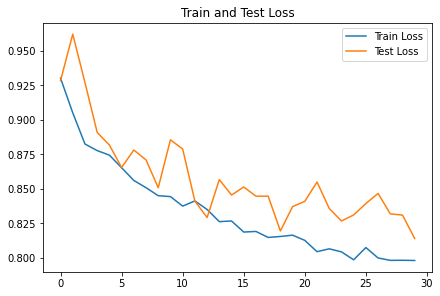

In [ ]:

plt.figure()
plt.title('Train and Test Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.show()

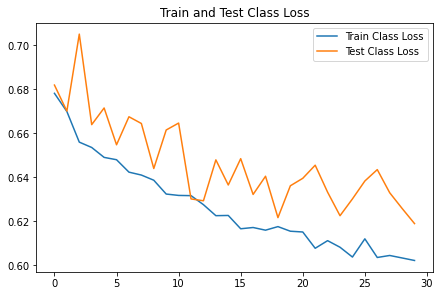

In [ ]:
plt.figure()
plt.title('Train and Test Class Loss')
plt.plot(train_class_loss, label='Train Class Loss')
plt.plot(test_class_loss, label='Test Class Loss')
plt.legend()
plt.show()

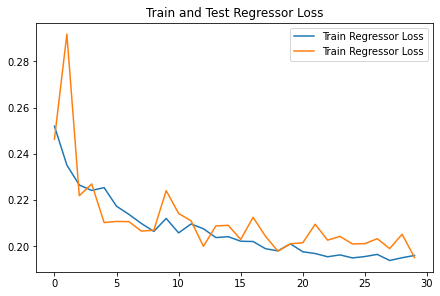

In [ ]:
plt.figure()
plt.title('Train and Test Regressor Loss')
plt.plot(train_regr_loss, label='Train Regressor Loss')
plt.plot(test_regr_loss, label='Train Regressor Loss')
plt.legend()
plt.show()

In [ ]:
# Load data into Dataset class
dataset = BuildDataset(paths)

# build the dataloader, set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

# random split the dataset into training and testset
torch.manual_seed(0)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# push the randomized training data into the dataloader
batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
model = RPNHead()
model.load_state_dict(torch.load('./model_trained.pth'))

<All keys matched successfully>

# 6. Pointwise Accuracy 

In [ ]:
anchors = model.get_anchors()
pointwise_accuracy = []

for idx, data in enumerate(test_loader):
  model.eval()
  images = data['images'][0]
  indices = data['index']
  bboxes = data['bbox']
  gt, ground_coord = model.create_batch_truth(bboxes, indices, images.shape[-2:])
  flattened_coord, flattened_gt, flattened_anchors = output_flattening(ground_coord, gt, anchors)
  
  clas_pred, coord_pred = model.forward(data['images'].float())
  flattened_coord_pred, flattened_clas_pred, flattened_anchors = output_flattening(coord_pred.detach(), clas_pred.detach(), anchors)

  prediction = flattened_clas_pred.clone()
  prediction[flattened_clas_pred>0.5] = 1
  prediction[flattened_clas_pred<0.5] = 0

  correct = torch.sum(prediction[flattened_gt==1])+ torch.sum(1 - prediction[flattened_gt==0])
  total = torch.sum(flattened_gt[flattened_gt==1])+torch.sum(1 - flattened_gt[flattened_gt==0])

  acc = correct/total
  pointwise_accuracy.append(acc)


In [ ]:
Accuracy = sum(pointwise_accuracy)/len(pointwise_accuracy) 
Accuracy = Accuracy * 100
print("Point wise accuracy = ", Accuracy.item(), "%")

Point wise accuracy =  63.696693420410156 %


# 7. Top 20 Proposals

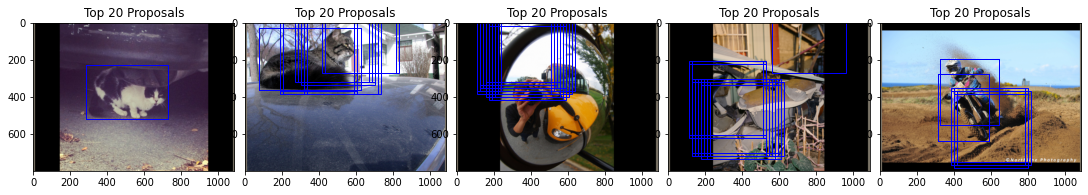

In [ ]:
which = 0
num=5
colors = ['r', 'b', 'g']

fig = plt.figure(figsize=(15, num))
fig.tight_layout()

for iter, data in enumerate(test_loader):
  model.eval()
  images  = data['images'][0]
  labels  = data['labels'][0]
  masks   = data['masks'][0]
  indexes = data['index']
  bboxes   = data['bbox']
  
  if len(labels)<=1:
      continue
  if (int(labels[0]) == int(labels[1])):
      continue

  # Create ground truth anchors
  gt, ground_coord = model.create_batch_truth(bboxes, indexes, images.shape[-2:])

  # Flatten the ground truth and the anchors
  flatten_coord, flatten_gt, flatten_anchors = output_flattening(ground_coord, gt, model.get_anchors())

  # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
  decoded_coord = output_decoding(flatten_coord, flatten_anchors)


  images = transforms.functional.normalize(images,
                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
  
  
  cls_out, reg_out = model.forward(data['images'].float())
  flatten_coord_pred,flatten_clas_pred,flatten_anchors=output_flattening(reg_out.detach(), cls_out.detach(), model.get_anchors())
  sort_clas,indices = torch.sort(flatten_clas_pred,dim = 0, descending=True)

  top_proposals = indices[:20]
  top_proposals_clas = sort_clas[:20]

  top_proposals_clas[top_proposals_clas>0] = 1
  top_proposals_reg = decoded_coord[top_proposals,:]


  # Pre and Post NMS
  # nms_clas_list, nms_prebox_list = model.postprocess(cls_out, reg_out, IOU_thresh=0.4)
  # nms_clas_list[0][nms_clas_list[0]>0] = 1

  # Plotting
  objs = len(labels)
  
  ax = fig.add_subplot(1, num, which + 1)
  ax.set_title('Top 20 Proposals')
  ax.imshow(torch.moveaxis(images, 0, -1))

  find_cor = (top_proposals_clas == 1).nonzero()
  find_neg = (top_proposals_clas == 0).nonzero()

  for elem in find_cor:
    coord = top_proposals_reg[elem, :].view(-1).detach().numpy()

    col = 'b'
    rect = patches.Rectangle((coord[0], coord[1]), coord[2] - coord[0], coord[3] - coord[1], fill=False,
                                color=col)
    ax.add_patch(rect)

  
  which+= 1

  if which == num:
      plt.show()
      break

# 8. Pre NMS & Post NMS

### 8.1 Pre NMS

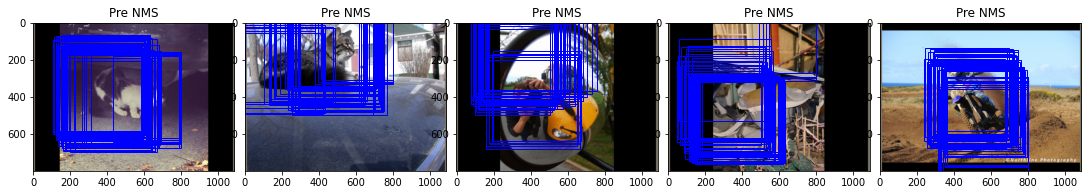

In [ ]:
which = 0
num=5
colors = ['r', 'b', 'g']

fig = plt.figure(figsize=(15, num))
fig.tight_layout()

for iter, data in enumerate(test_loader):
  model.eval()

  images  = data['images'][0]
  labels  = data['labels'][0]
  masks   = data['masks'][0]
  indexes = data['index']
  bboxes   = data['bbox']
  
  if len(labels)<=1:
      continue
  if (int(labels[0]) == int(labels[1])):
      continue



  images = transforms.functional.normalize(images,
                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)

  
  cls_out, reg_out = model.forward(data['images'].float())
  torch.save(cls_out, 'clas_out')
  torch.save(reg_out, 'reg_out')
  nms_clas_list, nms_prebox_list, top_proposed_class, top_proposed_reg  = model.postprocess(cls_out, reg_out, IOU_thresh=0.5)
  nms_clas_list[0][nms_clas_list[0]>0] = 1
  top_proposed_class[0][top_proposed_class[0]>0] = 1

  # Plotting
  objs = len(labels)
  
  ax = fig.add_subplot(1, num, which + 1)
  ax.set_title('Pre NMS')
  ax.imshow(torch.moveaxis(images, 0, -1))

  find_cor = (top_proposed_class[0] == 1).nonzero()
  find_neg = (top_proposed_class[0] == 0).nonzero()

  for elem in find_cor:
    coord = top_proposed_reg[0][elem, :].view(-1).detach().numpy()

    col = 'b'
    rect = patches.Rectangle((coord[0], coord[1]), coord[2] - coord[0], coord[3] - coord[1], fill=False,
                                color=col)
    ax.add_patch(rect)

  
  which+= 1

  if which == num:
      plt.show()
      break

### 8.2 Post NMS

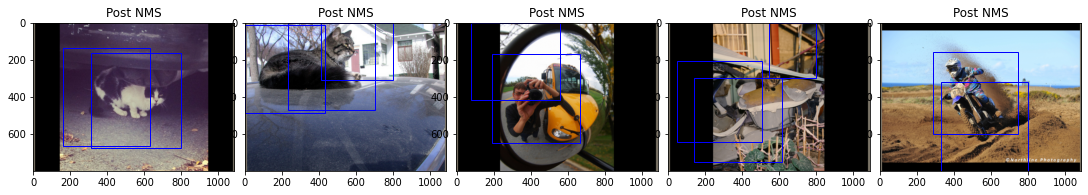

In [ ]:
which = 0
num=5
colors = ['r', 'b', 'g']

fig = plt.figure(figsize=(15, num))
fig.tight_layout()

for iter, data in enumerate(test_loader):
  model.eval()

  images  = data['images'][0]
  labels  = data['labels'][0]
  masks   = data['masks'][0]
  indexes = data['index']
  bboxes   = data['bbox']
  
  if len(labels)<=1:
      continue
  if (int(labels[0]) == int(labels[1])):
      continue



  images = transforms.functional.normalize(images,
                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)

  
  cls_out, reg_out = model.forward(data['images'].float())
  torch.save(cls_out, 'clas_out')
  torch.save(reg_out, 'reg_out')
  nms_clas_list, nms_prebox_list, top_proposed_class, top_proposed_reg  = model.postprocess(cls_out, reg_out, IOU_thresh=0.5)
  nms_clas_list[0][nms_clas_list[0]>0] = 1
  top_proposed_class[0][top_proposed_class[0]>0] = 1

  # Plotting
  objs = len(labels)
  
  ax = fig.add_subplot(1, num, which + 1)
  ax.set_title('Post NMS')
  ax.imshow(torch.moveaxis(images, 0, -1))

  find_cor = (nms_clas_list[0] == 1).nonzero()
  find_neg = (nms_clas_list[0] == 0).nonzero()

  for elem in find_cor:
    coord = nms_prebox_list[0][elem, :].view(-1).detach().numpy()

    col = 'b'
    rect = patches.Rectangle((coord[0], coord[1]), coord[2] - coord[0], coord[3] - coord[1], fill=False,
                                color=col)
    ax.add_patch(rect)

  
  which+= 1

  if which == num:
      plt.show()
      break